In [1]:
from pathlib import Path
import pandas as pd
import torchaudio, torch, librosa
from collections import Counter
from tqdm import tqdm
import numpy as np
import shutil

# ÏûÖÎ†• Î£®Ìä∏
ROOT = Path(r"D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞êÏ†ïÎ∂ÑÎ•òÎåÄÌôîÏùåÏÑ±\Í∞êÏ†ï Î∂ÑÎ•òÎ•º ÏúÑÌïú ÎåÄÌôî ÏùåÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖã")
PARTS = ["4Ï∞®", "5Ï∞®", "5_2Ï∞®"]

# Ï∂úÎ†• Î£®Ìä∏
OUTPUT_DIR = Path(r"D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\CHOI\datasets\KES_processed")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


In [5]:
label_map = {
    "Sadness": "sad", "sadness": "sad", "sad": "sad",
    "Angry": "angry", "anger": "angry", "angry": "angry",
    "Disgust": "disgust", "disgust": "disgust",
    "Fear": "fear", "fear": "fear",
    "Neutral": "neutral", "neutral": "neutral",
    "Happiness": "happiness", "happiness": "happiness",
    "Surprise": "surprise", "surprise": "surprise"
}

def load_and_clean(part_name):
    part_dir = ROOT / part_name
    csv_file = list(part_dir.glob("*.csv"))[0]
    df = pd.read_csv(csv_file, encoding="cp949")
    # Ïª¨ÎüºÎ™Ö ÍµêÏ†ï
    df = df.rename(columns={"4Î≤àÍ∞êÏ†ïÏÑ∏Í∏∞": "4Î≤à Í∞êÏ†ïÏÑ∏Í∏∞"})
    # annotator ÎùºÎ≤® Ï†ïÍ∑úÌôî
    for i in range(1, 6):
        col = f"{i}Î≤à Í∞êÏ†ï"
        if col in df.columns:
            df[col] = df[col].map(label_map)
    df["ÏÉÅÌô©"] = df["ÏÉÅÌô©"].map(label_map).fillna(df["ÏÉÅÌô©"])
    # wav Í≤ΩÎ°ú Ï∂îÍ∞Ä
    df["wav_path"] = df["wav_id"].apply(lambda x: str(part_dir / f"{x}.wav"))
    df["dataset_part"] = part_name
    return df

dfs = [load_and_clean(p) for p in PARTS]
full_df = pd.concat(dfs, ignore_index=True)

IndexError: list index out of range

In [ ]:
def vote_with_situation(row):
    labels = [row.get(f"{i}Î≤à Í∞êÏ†ï") for i in range(1, 6) if pd.notna(row.get(f"{i}Î≤à Í∞êÏ†ï"))]
    if not labels: return None
    cnt = Counter(labels)
    top = cnt.most_common()
    max_vote = top[0][1]
    candidates = [lab for lab, n in top if n == max_vote]

    if len(candidates) == 1:
        return candidates[0]

    # tie ‚Üí ÏÉÅÌô© 1Ìëú Ï∂îÍ∞Ä
    situation = row.get("ÏÉÅÌô©")
    if pd.notna(situation):
        cnt[situation] += 1
        top2 = cnt.most_common()
        max2 = top2[0][1]
        cands2 = [lab for lab, n in top2 if n == max2]
        if len(cands2) == 1:
            return cands2[0]

    return None  # Ïó¨Ï†ÑÌûà ÎèôÎ•†Ïù¥Î©¥ drop

full_df["emotion"] = full_df.apply(vote_with_situation, axis=1)
clean_df = full_df.dropna(subset=["emotion"]).copy()


In [3]:
import pyloudnorm as pyln

target_sr = 16000
meter = pyln.Meter(target_sr)  # LUFS meter

def preprocess_audio(path, out_dir, top_db=45):
    try:
        # 1) load
        y, sr = torchaudio.load(path)
        if y.shape[0] > 1:
            y = torch.mean(y, dim=0, keepdim=True)
        if sr != target_sr:
            y = torchaudio.functional.resample(y, sr, target_sr)
        y = y.squeeze().numpy()

        # 2) loudness normalize (LUFS)
        loudness = meter.integrated_loudness(y)
        y = pyln.normalize.loudness(y, loudness, -23.0)  # target = -23 LUFS

        # 3) peak normalize [-1,1]
        peak = np.max(np.abs(y))
        if peak > 0:
            y = y / peak

        # 4) RMS normalize (optional: match to -20 dBFS RMS)
        rms = np.sqrt(np.mean(y**2))
        target_rms = 10**(-20/20)
        if rms > 0:
            y = y * (target_rms / rms)

        # 5) ÏïûÎí§ Î¨¥ÏùåÎßå trim
        intervals = librosa.effects.split(y, top_db=top_db)
        if len(intervals) > 0:
            start, end = intervals[0][0], intervals[-1][1]
            y = y[start:end]

        # Ï†ÄÏû•
        dest = out_dir / (Path(path).stem + "_proc.wav")
        torchaudio.save(str(dest), torch.tensor(y).unsqueeze(0), target_sr)
        return dest, len(y)/target_sr

    except Exception as e:
        print(f"[ÏóêÎü¨] {path}: {e}")
        return None, None


# === ÏÉòÌîå ÏÑ†ÌÉù Î°úÏßÅ ===
clean_df["trim_ratio"] = clean_df["trim_duration"] / clean_df["raw_duration"]

# 20Ï¥à Ïù¥ÏÉÅ ÏÉòÌîå
long_samples = clean_df[clean_df["trim_duration"] > 20]

# ÎßéÏù¥ ÏûòÎ¶∞ Í≤É, Í±∞Ïùò Ïïà ÏûòÎ¶∞ Í≤É
most_trimmed_long = long_samples.sort_values("trim_ratio").head(10)
least_trimmed_long = long_samples.sort_values("trim_ratio", ascending=False).head(10)

# Ï†ÑÏ≤¥ÏóêÏÑú ÎßéÏù¥ ÏûòÎ¶∞ Í≤É
most_trimmed_all = clean_df.sort_values("trim_ratio").head(10)

# === Ï†ÑÏ≤òÎ¶¨ Î∞è Ï†ÄÏû• ===
OUT_DIR = OUTPUT_DIR / "preproc_audition"
OUT_DIR.mkdir(exist_ok=True)

for name, subset in {
    "most_trimmed_long": most_trimmed_long,
    "least_trimmed_long": least_trimmed_long,
    "most_trimmed_all": most_trimmed_all
}.items():
    print(f"\n=== {name} ===")
    for _, row in subset.iterrows():
        out_path, dur = preprocess_audio(row["wav_path"], OUT_DIR)
        if out_path:
            print(row["wav_path"], "->", out_path, "ratio:", row["trim_ratio"])


NameError: name 'clean_df' is not defined

In [26]:
# Ï†ÑÏ≤òÎ¶¨ ÌååÏù¥ÌîÑÎùºÏù∏ Ï∂îÍ∞Ä Î∂ÄÎ∂Ñ
import soundfile as sf
import pyloudnorm as pyln

target_sr = 16000

# 1) Loudness Normalize (LUFS Í∏∞Ï§Ä)
def loudness_normalize(path, target_lufs=-23.0, out_dir="normalized_wav"):
    y, sr = sf.read(path)
    meter = pyln.Meter(sr)
    loudness = meter.integrated_loudness(y)
    y_norm = pyln.normalize.loudness(y, loudness, target_lufs)

    out_dir = Path(out_dir); out_dir.mkdir(exist_ok=True)
    out_path = out_dir / f"{Path(path).stem}_norm.wav"
    sf.write(out_path, y_norm, sr)
    return str(out_path), loudness

# clean_df["norm_path"], clean_df["orig_loudness"] = zip(*clean_df["wav_path"].map(loudness_normalize))

In [27]:
# 2) Peak + RMS Normalize (Î≥¥Ï°∞, clipping Î∞©ÏßÄ & ÌèâÍ∑† ÏóêÎÑàÏßÄ ÏïàÏ†ïÌôî)
def peak_normalize(y):
    return y / (np.max(np.abs(y)) + 1e-8)

def rms_normalize(y, target_rms=0.05):
    rms = np.sqrt(np.mean(y**2))
    return y * (target_rms / (rms + 1e-8))

In [28]:
# 3) Head-tail VAD (top_db=45)
def head_tail_trim(y, sr, top_db=45):
    intervals = librosa.effects.split(y, top_db=top_db)
    if len(intervals) == 0:
        return y
    start, end = intervals[0][0], intervals[-1][1]
    return y[start:end]

In [40]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def process_wav(path, target_lufs=-23.0, top_db=45):
    try:
        # 1) wav load (torchaudio ‚Üí numpy)
        y, sr = torchaudio.load(path)
        if y.shape[0] > 1:      # Ïä§ÌÖåÎ†àÏò§ ‚Üí Î™®ÎÖ∏
            y = torch.mean(y, dim=0, keepdim=True)
        y = y.squeeze(0).numpy()

        raw_len = len(y) / sr

        # 3) Loudness normalize (Î©îÎ™®Î¶¨ array Í∏∞Ï§Ä)
        meter = pyln.Meter(sr)
        loudness = meter.integrated_loudness(y)
        y = pyln.normalize.loudness(y, loudness, target_lufs)

        # 2) Head-tail VAD
        y_trim = head_tail_trim(y, sr, top_db=top_db)

        # 4) Peak + RMS normalize (Î≥¥Ï°∞ ÏïàÏ†ïÌôî)
        y_trim = peak_normalize(y_trim)
        y_trim = rms_normalize(y_trim)

        trim_len = len(y_trim) / sr
        ratio = trim_len / raw_len if raw_len > 0 else 0.0
        tail_sil = raw_len - trim_len

        return raw_len, trim_len, ratio, tail_sil, loudness

    except Exception as e:
        print(f"[ERROR] {path} - {e}")
        return None, None, None, None, None

In [43]:
num_workers = 5
results = []
with ThreadPoolExecutor(max_workers=num_workers) as executor:
    for r in tqdm(executor.map(process_wav, clean_df["wav_path"]),
                  total=len(clean_df), desc="Preprocessing"):
        results.append(r)

clean_df[["raw_duration","trim_duration","speech_ratio","tail_silence_sec","orig_loudness"]] = \
    pd.DataFrame(results, index=clean_df.index)


Preprocessing:   0%|          | 0/42408 [00:00<?, ?it/s]d:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\.venv\lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
d:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\.venv\lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
d:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\.venv\lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
d:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\.venv\lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
d:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\.venv\lib\site-packages\pyloudnorm\normalize.py:62: UserWarning: Possible clippe

In [41]:
test=process_wav(Path(r'D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞êÏ†ïÎ∂ÑÎ•òÎåÄÌôîÏùåÏÑ±\Í∞êÏ†ï Î∂ÑÎ•òÎ•º ÏúÑÌïú ÎåÄÌôî ÏùåÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖã\4Ï∞®\5e2ac3d55807b852d9e01fd6.wav'))

In [45]:
clean_df

wav_id                        Î∞úÌôîÎ¨∏         ÏÉÅÌô©  \
0      5e258fd1305bcf3ad153a6a4           Ïñ¥, Ï≤≠ÏÜå ÎãàÍ∞Ä ÎåÄÏã† Ìï¥ Ï§ò!      angry   
1      5e258fe2305bcf3ad153a6a5         Îëò Îã§ Ï≤≠ÏÜå ÌïòÍ∏∞ Ïã´Ïñ¥. Í∑ÄÏ∞ÆÏïÑ.      angry   
2      5e258ff5305bcf3ad153a6a6             Îëò Îã§ ÌïòÍ∏∞ Ïã´Ïñ¥ÏÑú ÌôîÎÇ¥.      angry   
3      5e25902f305bcf3ad153a6a9                Í∑∏Îüº Î∞©ÏÑ∏Îäî Ïñ¥Îñ°Ìï¥.      angry   
4      5e27f90b5807b852d9e0157b  Í∂åÌÉúÍ∏¥Ï§Ñ ÏïåÏïòÎäîÎç∞ Îã§Î•∏ ÏÇ¨ÎûåÏù¥ ÏÉùÍ≤ºÎÇòÎ≥¥ÎçîÎùºÍ≥†.        sad   
...                         ...                        ...        ...   
43970  5fbe313c44697678c497c05a              ÎÇò ÏóòÎ¶¨Î≤†Ïù¥ÌÑ∞Ïóê Í∞áÌòîÏñ¥.       fear   
43971  5fbe251044697678c497bfb8          ÌïòÏßÄÎßå Í∏∞Î∂ÑÏù¥ ÎÇòÏÅú Í±∏ Ïñ¥Îñ°Ìï¥?      angry   
43972  5fbe31584c55eb78bd7cee7f          ÏûêÏ∑®Î∞© ÏóòÎ¶¨Î≤†Ïù¥ÌÑ¥Îç∞ Ï†ïÏ†ÑÏù∏Í∞ÄÎ¥ê.       fear   
43973  5fbe2f8544697678c497c047            ÎÇò ÎìúÎîîÏñ¥ ÌîÑÎ°úÏ†ùÌä∏ ÎÅùÎÇ¨Ïñ¥!  happiness   
43974  5fbe36714c55eb78bd7ceea3                 Í±±Ï†ïÌï¥Ï§òÏÑú Í≥†ÎßàÏõå.    disgust   

           1Î≤à Í∞êÏ†ï  1Î≤à Í∞êÏ†ïÏÑ∏Í∏∞    2Î≤à Í∞êÏ†ï  2Î≤à Í∞êÏ†ïÏÑ∏Í∏∞    3Î≤à Í∞êÏ†ï  3Î≤à Í∞êÏ†ïÏÑ∏Í∏∞      4Î≤à Í∞êÏ†ï  ...  \
0        neutral        0    angry        1  neutral        0    neutral  ...   
1        neutral        0    angry        1  neutral        0    neutral  ...   
2          angry        1    angry        1  neutral        0      angry  ...   
3            sad        1      sad        1      sad        1        sad  ...   
4            sad        1      sad        1      sad        1        sad  ...   
...          ...      ...      ...      ...      ...      ...        ...  ...   
43970  happiness        1      sad        1      sad        2        sad  ...   
43971        sad        1     fear        1      sad        2        sad  ...   
43972        sad        1  neutral        0      sad        2       fear  ...   
43973    disgust        1      sad        1  neutral        0  happiness  ...   
43974    neutral        0  neutral        0  neutral        0    neutral  ...   

                                                wav_path exists  dataset_part  \
0      D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   True            4Ï∞®   
1      D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   True            4Ï∞®   
2      D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   True            4Ï∞®   
3      D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   True            4Ï∞®   
4      D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   True            4Ï∞®   
...                                                  ...    ...           ...   
43970  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   True          5_2Ï∞®   
43971  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   True          5_2Ï∞®   
43972  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   True          5_2Ï∞®   
43973  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   True          5_2Ï∞®   
43974  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   True          5_2Ï∞®   

       emotion raw_duration trim_duration  speech_ratio tail_silence_sec  \
0      neutral     3.285333      3.242667      0.987013         0.042667   
1      neutral     3.200000      3.114667      0.973333         0.085333   
2        angry     3.413333      3.328000      0.975000         0.085333   
3          sad     3.200000      3.114667      0.973333         0.085333   
4          sad    10.880000     10.784000      0.991176         0.096000   
...        ...          ...           ...           ...              ...   
43970      sad     2.901333      2.805333      0.966912         0.096000   
43971      sad     3.882667      3.786667      0.975275         0.096000   
43972      sad     3.669333      3.584000      0.976744         0.0853

In [48]:
# =========================
# 4) EDA Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏
# =========================
clean_df["trim_ratio"] = clean_df["trim_duration"] / clean_df["raw_duration"]

most_trimmed = clean_df.sort_values("trim_ratio").head(10)
long_samples = clean_df[clean_df["trim_duration"] > 20]

print("=== ÎßéÏù¥ ÏûòÎ¶∞ ÏÉòÌîå (ratio ÎÇÆÏùå, ÏÉÅÏúÑ 10Í∞ú) ===")
print(most_trimmed[["wav_id","emotion","raw_duration","trim_duration","trim_ratio"]])

print("\n=== 20Ï¥à Ïù¥ÏÉÅ Í∏¥ ÏÉòÌîå ===")
print(long_samples[["wav_id","emotion","raw_duration","trim_duration","trim_ratio"]])


# =========================
# 20Ï¥à Ïù¥ÏÉÅ ÏÉòÌîåÎßå ÎåÄÏÉÅÏúºÎ°ú 2Ï∞® VAD ÏàòÌñâ & Ï†ÄÏû•
# =========================
# def run_two_stage_vad(path, top_db_stage1=45, top_db_stage2=30):
#     # load
#     y, sr = torchaudio.load(path)
#     if y.shape[0] > 1:
#         y = torch.mean(y, dim=0, keepdim=True)
#     y = y.squeeze(0).numpy()

#     raw_len = len(y)/sr

#     # 1Ï∞® VAD (45)
#     y_trim = head_tail_trim(y, sr, top_db=top_db_stage1)

#     # 2Ï∞® VAD (30)
#     y_trim2 = head_tail_trim(y_trim, sr, top_db=top_db_stage2)

#     trim_len = len(y_trim2)/sr
#     ratio = trim_len/raw_len if raw_len > 0 else 0.0

#     return raw_len, trim_len, ratio, sr, y_trim2


# 20Ï¥à Ïù¥ÏÉÅÏù∏ ÏÉòÌîå ÎåÄÏÉÅÏúºÎ°ú Ïã§Ìñâ
long_samples = clean_df[clean_df["trim_duration"] > 20].copy()
results = []
for _, row in long_samples.iterrows():
    raw, trim, ratio, sr, y_trim = process_wav(row["wav_path"])
    results.append({
        "wav_id": row["wav_id"],
        "emotion": row["emotion"],
        "src": row["wav_path"],
        "raw": raw,
        "trim": trim,
        "ratio": ratio,
        "y_trim": y_trim,
        "sr": sr
    })
df_results = pd.DataFrame(results)

# ratio Í∏∞Ï§Ä Ï†ïÎ†¨
df_sorted = df_results.sort_values("ratio")

# ÎßéÏù¥ ÏûòÎ¶∞ 5Í∞ú / Í±∞Ïùò Ïïà ÏûòÎ¶∞ 5Í∞ú
most_trimmed2 = df_sorted.head(5).sort_values("wav_id", ascending=True)
least_trimmed2 = df_sorted.tail(5).sort_values("wav_id", ascending=True)

# =========================
# ÎßéÏù¥ ÏûòÎ¶∞ / Í∏¥ ÏÉòÌîå Ï†ÄÏû• (Ï†ÑÏ≤òÎ¶¨ Î≤ÑÏ†Ñ)
# =========================
out_dir_most = Path("eda_samples_most"); out_dir_most.mkdir(exist_ok=True)
out_dir_long = Path("eda_samples_long"); out_dir_long.mkdir(exist_ok=True)

# ÎßéÏù¥ ÏûòÎ¶∞ ÏÉÅÏúÑ 5Í∞ú
for _, row in most_trimmed.head(5).sort_values("wav_id").iterrows():
    raw, trim, ratio, tail_sil, loudness, y_trim, sr = process_wav(row["wav_path"])
    if y_trim is not None:
        out_path = out_dir_most / f"{row['wav_id']}_eda.wav"
        torchaudio.save(str(out_path), torch.tensor(y_trim).unsqueeze(0), sr)
        print(f"[MOST] Ï†ÄÏû•: {out_path} (raw={raw:.2f}s, trim={trim:.2f}s, ratio={ratio:.2f})")

# Í∏¥ ÏÉòÌîå ÏÉÅÏúÑ 5Í∞ú
for _, row in long_samples.head(5).sort_values("wav_id").iterrows():
    raw, trim, ratio, tail_sil, loudness, y_trim, sr = process_wav(row["wav_path"])
    if y_trim is not None:
        out_path = out_dir_long / f"{row['wav_id']}_eda.wav"
        torchaudio.save(str(out_path), torch.tensor(y_trim).unsqueeze(0), sr)
        print(f"[LONG] Ï†ÄÏû•: {out_path} (raw={raw:.2f}s, trim={trim:.2f}s, ratio={ratio:.2f})")


=== ÎßéÏù¥ ÏûòÎ¶∞ ÏÉòÌîå (ratio ÎÇÆÏùå, ÏÉÅÏúÑ 10Í∞ú) ===
                         wav_id    emotion  raw_duration  trim_duration  \
43618  5fbdecee576e9378b67ad2eb        sad      6.272000       1.258667   
43644  5fbdeeae44697678c497be94    neutral      4.010667       0.853333   
42780  5fbc9e2d576e9378b67acf13    neutral      6.997333       1.514667   
36920  5fba1667576e9378b67ac752    neutral      4.906667       1.120000   
43827  5fbe24ae576e9378b67ad3e1    neutral      4.906667       1.216000   
32023  5f85c4fd111dfd48d40fdfbf  happiness      3.328000       0.842667   
42537  5fbca227576e9378b67acf4b        sad      6.016000       1.525333   
43065  5fbd0d2e4c55eb78bd7ceaed    disgust     11.136000       3.008000   
39727  5fb9c1414c55eb78bd7cdf7b    neutral      4.821333       1.333333   
41012  5fbb163e576e9378b67ac920    neutral      5.504000       1.525333   

       trim_ratio  
43618    0.200680  
43644    0.212766  
42780    0.216463  
36920    0.228261  
43827    0.24782

ValueError: not enough values to unpack (expected 7, got 5)

In [47]:
# EDA Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏
clean_df["trim_ratio"] = clean_df["trim_duration"] / clean_df["raw_duration"]

most_trimmed = clean_df.sort_values("trim_ratio").head(10)
long_samples = clean_df[clean_df["trim_duration"] > 20]

print("=== ÎßéÏù¥ ÏûòÎ¶∞ ÏÉòÌîå ===")
print(most_trimmed[["wav_id","emotion","raw_duration","trim_duration","trim_ratio"]])

print("\n=== 20Ï¥à Ïù¥ÏÉÅ Í∏¥ ÏÉòÌîå ===")
print(long_samples[["wav_id","emotion","raw_duration","trim_duration","trim_ratio"]])

# ÏÉòÌîå Ï†ÄÏû•: ratio ÎÇÆÏùÄ 5Í∞ú / ÎÜíÏùÄ 5Í∞ú
df_sorted = long_samples.sort_values("trim_ratio")
most_trimmed2 = df_sorted.head(5).sort_values("wav_id")
least_trimmed2 = df_sorted.tail(5).sort_values("wav_id")

out_dir_most = Path("vad_stage2_most"); out_dir_most.mkdir(exist_ok=True)
out_dir_least = Path("vad_stage2_least"); out_dir_least.mkdir(exist_ok=True)

for _, row in most_trimmed2.iterrows():
    y, sr = torchaudio.load(row["wav_path"])
    out_path = out_dir_most / f"{Path(row['wav_path']).stem}_trim2.wav"
    torchaudio.save(str(out_path), y, sr)
    print(f"[MOST] ÏõêÎ≥∏={row['wav_path']} ‚Üí Ï†ÄÏû•={out_path}")

for _, row in least_trimmed2.iterrows():
    y, sr = torchaudio.load(row["wav_path"])
    out_path = out_dir_least / f"{Path(row['wav_path']).stem}_trim2.wav"
    torchaudio.save(str(out_path), y, sr)
    print(f"[LEAST] ÏõêÎ≥∏={row['wav_path']} ‚Üí Ï†ÄÏû•={out_path}")

=== ÎßéÏù¥ ÏûòÎ¶∞ ÏÉòÌîå ===
                         wav_id    emotion  raw_duration  trim_duration  \
43618  5fbdecee576e9378b67ad2eb        sad      6.272000       1.258667   
43644  5fbdeeae44697678c497be94    neutral      4.010667       0.853333   
42780  5fbc9e2d576e9378b67acf13    neutral      6.997333       1.514667   
36920  5fba1667576e9378b67ac752    neutral      4.906667       1.120000   
43827  5fbe24ae576e9378b67ad3e1    neutral      4.906667       1.216000   
32023  5f85c4fd111dfd48d40fdfbf  happiness      3.328000       0.842667   
42537  5fbca227576e9378b67acf4b        sad      6.016000       1.525333   
43065  5fbd0d2e4c55eb78bd7ceaed    disgust     11.136000       3.008000   
39727  5fb9c1414c55eb78bd7cdf7b    neutral      4.821333       1.333333   
41012  5fbb163e576e9378b67ac920    neutral      5.504000       1.525333   

       trim_ratio  
43618    0.200680  
43644    0.212766  
42780    0.216463  
36920    0.228261  
43827    0.247826  
32023    0.253205  
42537

LibsndfileError: Error opening 'D:\\ex\\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\\AI_Dev_3rd_Project\\YEO\\datasets\\Í∞êÏ†ïÎ∂ÑÎ•òÎåÄÌôîÏùåÏÑ±\\Í∞êÏ†ï Î∂ÑÎ•òÎ•º ÏúÑÌïú ÎåÄÌôî ÏùåÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖã\\4Ï∞®\\5e34c2875807b852d9e067a8.wav': System error.

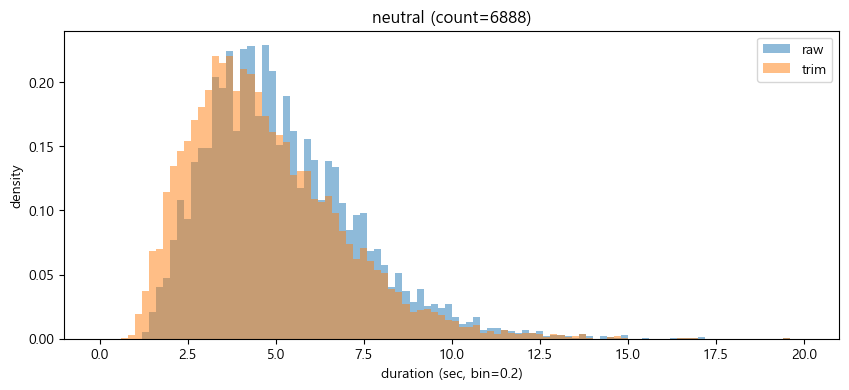

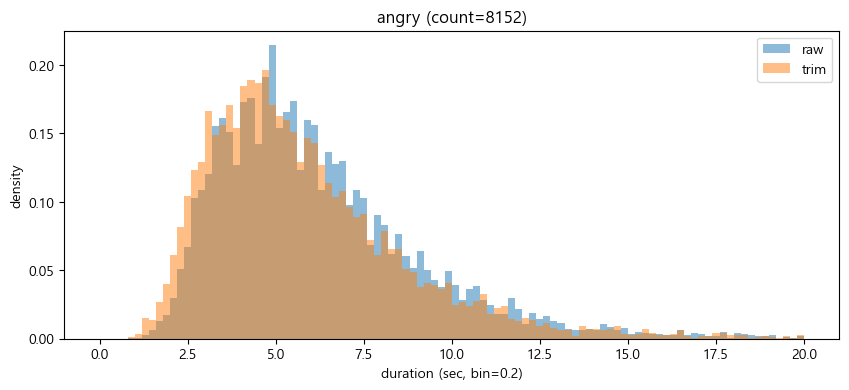

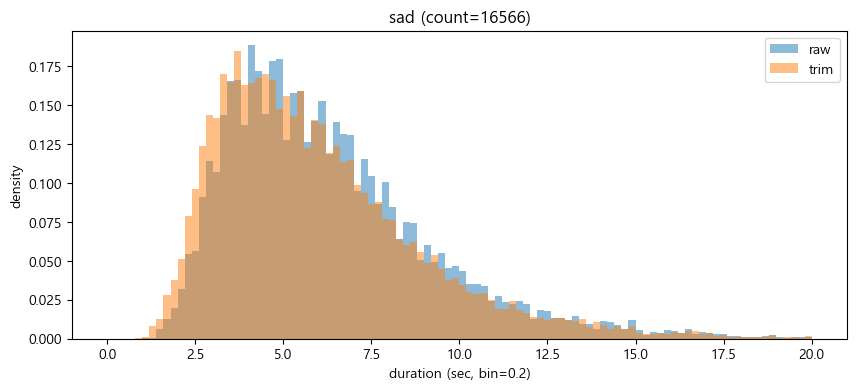

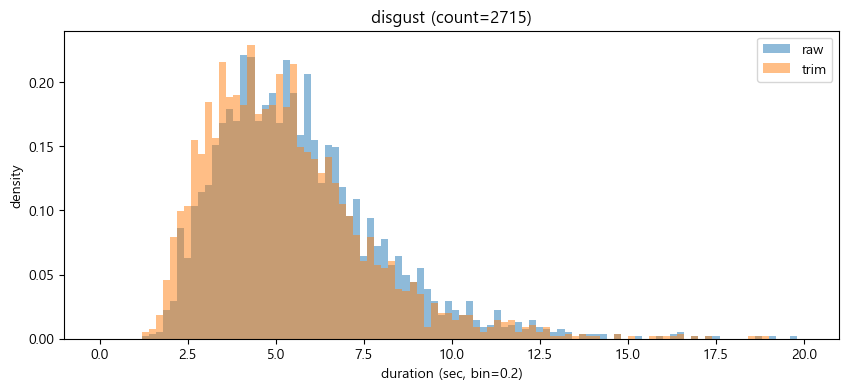

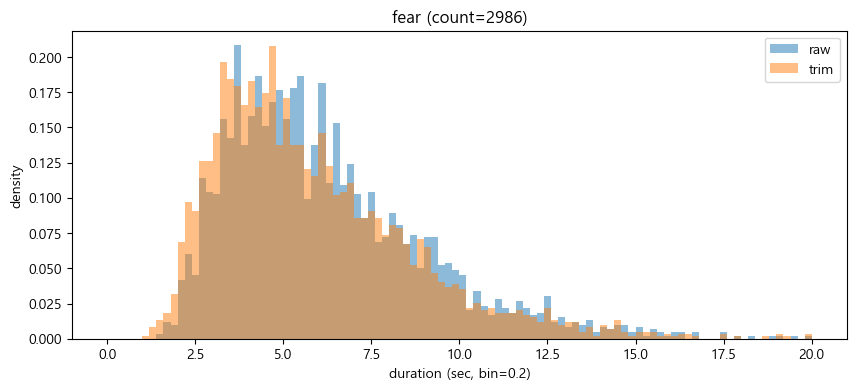

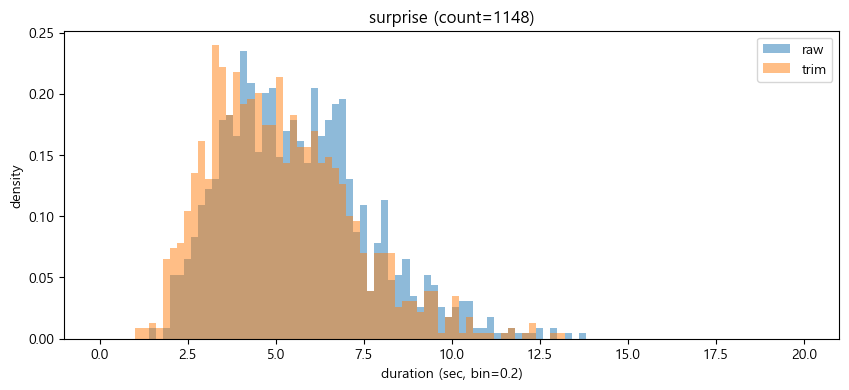

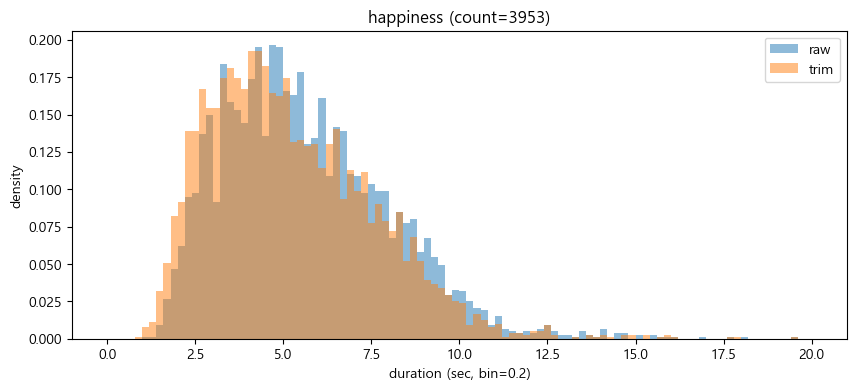

In [35]:
import numpy as np
import matplotlib.pyplot as plt

BIN = 0.2
MAX_SEC = 20.0
bins = np.arange(0, MAX_SEC+BIN, BIN)

# Í∞êÏ†ïÎ≥Ñ ÌûàÏä§ÌÜ†Í∑∏Îû® (raw vs trim ÎπÑÍµê)
emotions = clean_df['emotion'].unique()

for emo in emotions:
    subset = clean_df[clean_df['emotion'] == emo]
    raw = subset['raw_duration'].dropna()
    trim = subset['trim_duration'].dropna()

    plt.figure(figsize=(10,4))
    plt.hist(raw, bins=bins, alpha=0.5, label='raw', density=True)
    plt.hist(trim, bins=bins, alpha=0.5, label='trim', density=True)
    plt.title(f"{emo} (count={len(subset)})")
    plt.xlabel("duration (sec, bin=0.2)")
    plt.ylabel("density")
    plt.legend()
    plt.show()


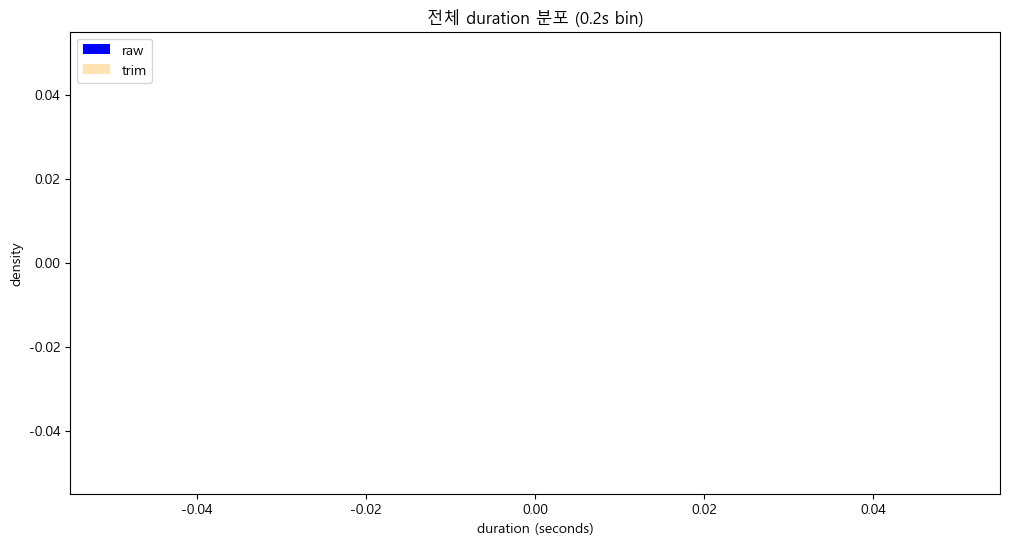

In [9]:
import matplotlib.pyplot as plt
import numpy as np

BIN = 0.2
MAX_SEC = 20.0
bins_02 = np.arange(0, MAX_SEC+BIN, BIN)

raw = clean_df['raw_duration'].dropna()
trim = clean_df['trim_duration'].dropna()

plt.figure(figsize=(12,6))
plt.hist(raw, bins=bins_02, alpha=1, label='raw', density=True, color='blue')
plt.hist(trim, bins=bins_02, alpha=0.3, label='trim', density=True, color='orange')
plt.title("Ï†ÑÏ≤¥ duration Î∂ÑÌè¨ (0.2s bin)")
plt.xlabel("duration (seconds)")
plt.ylabel("density")
plt.legend()
plt.show()


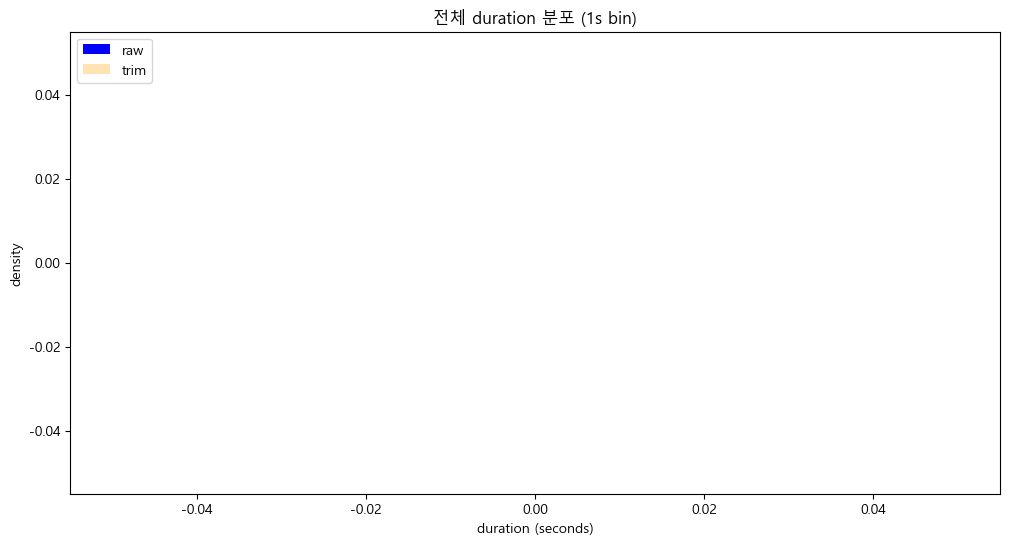

In [10]:
BIN = 1.0
MAX_SEC = 30.0  # ÌïÑÏöîÏãú ÎäòÎ†§ÎèÑ Îê®
bins_1 = np.arange(0, MAX_SEC+BIN, BIN)

plt.figure(figsize=(12,6))
plt.hist(raw, bins=bins_1, alpha=1, label='raw', density=True, color='blue')
plt.hist(trim, bins=bins_1, alpha=0.3, label='trim', density=True, color='orange')
plt.title("Ï†ÑÏ≤¥ duration Î∂ÑÌè¨ (1s bin)")
plt.xlabel("duration (seconds)")
plt.ylabel("density")
plt.legend()
plt.show()


In [11]:
def ensure_agreement_ratio(df):
    ann_cols = [f"{i}Î≤à Í∞êÏ†ï" for i in range(1, 6)]
    def _agg(row):
        votes = [row.get(c) for c in ann_cols if pd.notna(row.get(c))]
        if not votes: return pd.Series({"agreement_ratio": 0})
        cnt = Counter(votes)
        top = cnt.most_common(1)[0][1]
        return pd.Series({"agreement_ratio": top/len(votes)})
    out = df.apply(_agg, axis=1)
    df["agreement_ratio"] = out["agreement_ratio"]
    return df

clean_df = ensure_agreement_ratio(clean_df)

# Ïò§ÎîîÏò§ ÌíàÏßà Í≥ÑÏÇ∞
def compute_quality(path, target_sr=16000):
    try:
        y, sr = torchaudio.load(path)
        if y.shape[0] > 1:
            y = torch.mean(y, dim=0, keepdim=True)
        if sr != target_sr:
            y = torchaudio.functional.resample(y, sr, target_sr)
        y = y.squeeze().numpy()
        dur = len(y)/target_sr
        rms = np.sqrt(np.mean(y**2))+1e-8
        peak = np.max(np.abs(y))
        crest = peak/rms
        clip_ratio = np.mean(np.abs(y) >= 0.99)
        noise_floor = np.percentile(np.abs(y), 10)
        snr_proxy = 20*np.log10(rms/(noise_floor+1e-8))
        return dur, crest, clip_ratio, snr_proxy
    except:
        return None, None, None, None

q_metrics = []
for p in tqdm(clean_df["wav_path"], desc="quality"):
    d,c,cl,s = compute_quality(p)
    q_metrics.append((d,c,cl,s))
clean_df[["duration","crest","clipping_ratio","snr_proxy_db"]] = pd.DataFrame(q_metrics)

filtered_df = clean_df[
    (clean_df["agreement_ratio"]>=0.6) &
    (clean_df["duration"]>=0.2) &
    (clean_df["snr_proxy_db"]>=10) &
    (clean_df["crest"]<=30) &
    (clean_df["clipping_ratio"]<=0.01)
].copy()


quality: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42408/42408 [06:21<00:00, 111.10it/s]


Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: 35434

Ïª¨Îüº Î™©Î°ù: ['wav_id', 'Î∞úÌôîÎ¨∏', 'ÏÉÅÌô©', '1Î≤à Í∞êÏ†ï', '1Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '2Î≤à Í∞êÏ†ï', '2Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '3Î≤à Í∞êÏ†ï', '3Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '4Î≤à Í∞êÏ†ï', '4Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '5Î≤à Í∞êÏ†ï', '5Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', 'ÎÇòÏù¥', 'ÏÑ±Î≥Ñ', 'wav_path', 'exists', 'dataset_part', 'emotion', 'raw_duration', 'trim_duration', 'speech_ratio', 'tail_silence_sec', 'orig_loudness', 'trim_ratio', 'agreement_ratio', 'duration', 'crest', 'clipping_ratio', 'snr_proxy_db']

ÏÉòÌîå 5Ìñâ:
                     wav_id                        Î∞úÌôîÎ¨∏     ÏÉÅÌô©    1Î≤à Í∞êÏ†ï  \
0  5e258fd1305bcf3ad153a6a4           Ïñ¥, Ï≤≠ÏÜå ÎãàÍ∞Ä ÎåÄÏã† Ìï¥ Ï§ò!  angry  neutral   
1  5e258fe2305bcf3ad153a6a5         Îëò Îã§ Ï≤≠ÏÜå ÌïòÍ∏∞ Ïã´Ïñ¥. Í∑ÄÏ∞ÆÏïÑ.  angry  neutral   
2  5e258ff5305bcf3ad153a6a6             Îëò Îã§ ÌïòÍ∏∞ Ïã´Ïñ¥ÏÑú ÌôîÎÇ¥.  angry    angry   
3  5e25902f305bcf3ad153a6a9                Í∑∏Îüº Î∞©ÏÑ∏Îäî Ïñ¥Îñ°Ìï¥.  angry      sad   
4  5e27f90b5807b852d9e0157b  

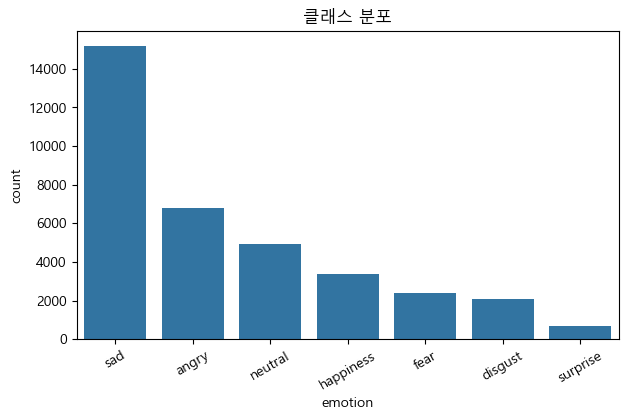


=== Í∞êÏ†ïÎ≥Ñ ÌèâÍ∑† ÌíàÏßà Î©îÌä∏Î¶≠ ===
           duration  snr_proxy_db     crest  clipping_ratio  agreement_ratio
emotion                                                                     
angry      6.230913     42.730829  8.861448    2.903595e-07         0.810929
disgust    5.910441     42.761426  8.891729    5.646240e-07         0.810480
fear       6.128980     42.456663  8.619248    2.632788e-07         0.791146
happiness  5.808141     42.917490  8.753852    4.308283e-07         0.823659
neutral    5.509598     45.590028  9.522281    1.740286e-06         0.700344
sad        6.258279     42.813019  8.736243    2.277985e-07         0.859015
surprise   5.649274     43.053127  8.763359    5.409038e-07         0.691594


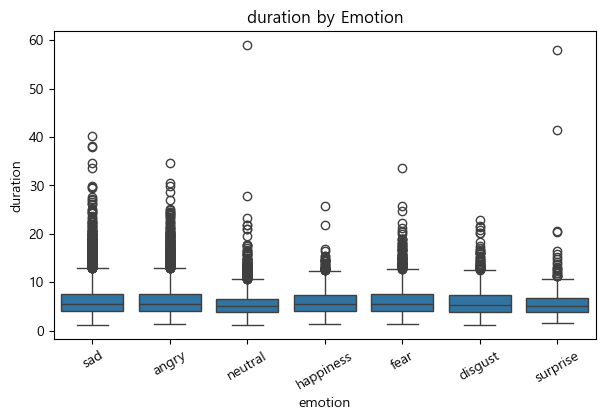

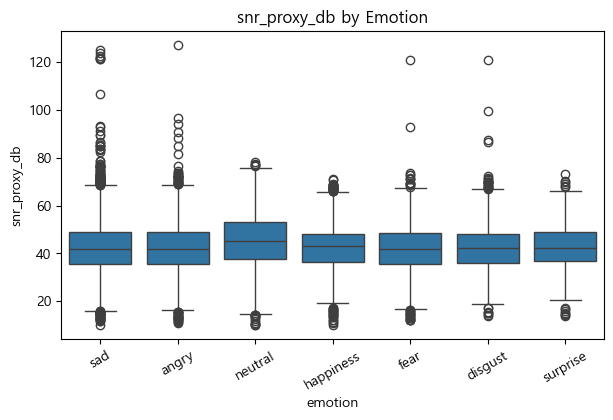

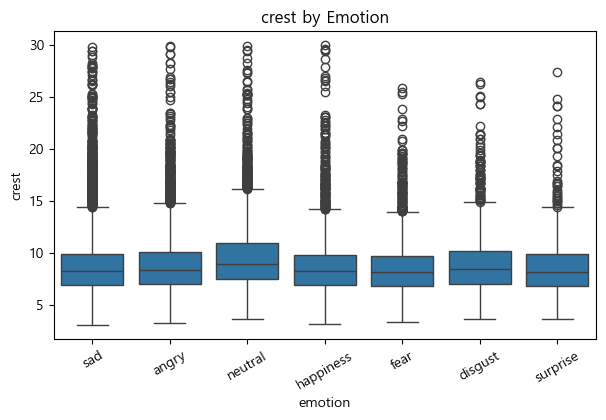

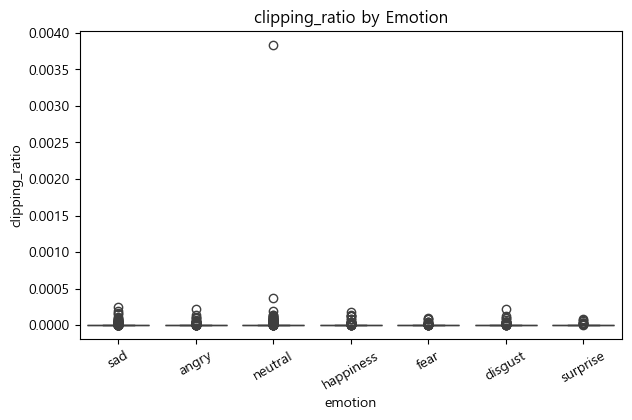

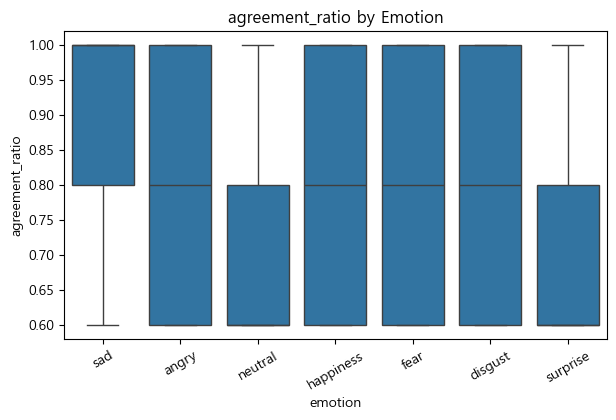

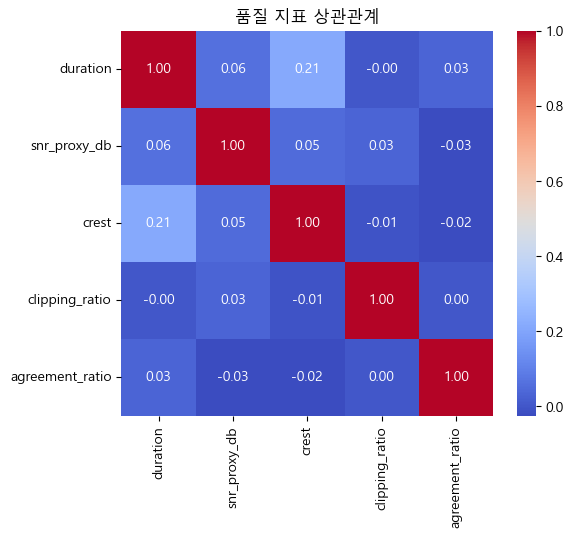

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------
# 1. Í∏∞Î≥∏ Ï†ïÎ≥¥
# ------------------------------
print("Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞:", len(filtered_df))
print("\nÏª¨Îüº Î™©Î°ù:", filtered_df.columns.tolist())
print("\nÏÉòÌîå 5Ìñâ:")
print(filtered_df.head())

# ------------------------------
# 2. ÏàòÏπòÌòï Í∏∞Ïà† ÌÜµÍ≥Ñ
# ------------------------------
num_cols = ["duration", "snr_proxy_db", "crest", "clipping_ratio", "agreement_ratio"]
print("\n=== Í∏∞Ïà† ÌÜµÍ≥Ñ ÏöîÏïΩ ===")
print(filtered_df[num_cols].describe())

# ------------------------------
# 3. ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨
# ------------------------------
print("\n=== ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨ ===")
print(filtered_df["emotion"].value_counts())

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(7,4))
sns.countplot(x="emotion", data=filtered_df, order=filtered_df["emotion"].value_counts().index)
plt.title("ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨")
plt.xticks(rotation=30)
plt.show()

# ------------------------------
# 4. Í∞êÏ†ïÎ≥Ñ ÌèâÍ∑† ÌíàÏßà Î©îÌä∏Î¶≠
# ------------------------------
print("\n=== Í∞êÏ†ïÎ≥Ñ ÌèâÍ∑† ÌíàÏßà Î©îÌä∏Î¶≠ ===")
print(filtered_df.groupby("emotion")[num_cols].mean())

# boxplotÏúºÎ°ú Í∞êÏ†ïÎ≥Ñ ÌíàÏßà Î∂ÑÌè¨ ÎπÑÍµê
for col in num_cols:
    plt.figure(figsize=(7,4))
    sns.boxplot(x="emotion", y=col, data=filtered_df, order=filtered_df["emotion"].value_counts().index)
    plt.title(f"{col} by Emotion")
    plt.xticks(rotation=30)
    plt.show()

# ------------------------------
# 5. ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Îß§Ìä∏Î¶≠Ïä§
# ------------------------------
corr = filtered_df[num_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("ÌíàÏßà ÏßÄÌëú ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ")
plt.show()


In [13]:
target_sr = 16000

def process_and_save(row, out_dir=OUTPUT_DIR):
    src = Path(row["wav_path"])
    if not src.exists(): return None
    wav_id = row["wav_id"]

    y, sr = torchaudio.load(src)
    if y.shape[0] > 1:
        y = torch.mean(y, dim=0, keepdim=True)
    if sr != target_sr:
        y = torchaudio.functional.resample(y, sr, target_sr)
    y = y.squeeze().numpy()
    y = y/np.max(np.abs(y)+1e-8)

    L = len(y)/target_sr
    nseg = int(L//8)
    segments = []
    # Ï†ïÏàò ÏÑ∏Í∑∏Î®ºÌä∏
    for i in range(nseg):
        seg = y[i*8*target_sr:(i+1)*8*target_sr]
        dest = out_dir / f"{wav_id}__seg_{i:03d}.wav"
        torchaudio.save(str(dest), torch.tensor(seg).unsqueeze(0), target_sr)
        segments.append(dest.name)

    # ÏûîÏó¨ Ï≤òÎ¶¨
    r = L % 8
    remainder = y[nseg*8*target_sr:]

    if L < 8:
        # üî• 8Ï¥à ÎØ∏Îßå Î∞úÌôîÎèÑ Î¨¥Ï°∞Í±¥ padÌï¥ÏÑú 1Í∞ú ÏÑ∏Í∑∏Î®ºÌä∏ ÏÉùÏÑ±
        seg = np.pad(y, (0, int(8*target_sr - len(y))))
        dest = out_dir / f"{wav_id}__seg_000.wav"
        torchaudio.save(str(dest), torch.tensor(seg).unsqueeze(0), target_sr)
        segments.append(dest.name)

    elif r > 0:
        if r >= 4:
            seg = np.pad(remainder, (0, int(8*target_sr - len(remainder))))
            dest = out_dir / f"{wav_id}__seg_{nseg:03d}.wav"
            torchaudio.save(str(dest), torch.tensor(seg).unsqueeze(0), target_sr)
            segments.append(dest.name)
        # r < 4Îäî Î≤ÑÎ¶º (Í∏¥ Î∞úÌôî ÏûîÏó¨)
    return segments

records = []
for _, row in tqdm(filtered_df.iterrows(), total=len(filtered_df), desc="segmenting"):
    segs = process_and_save(row)
    if segs:
        for s in segs:
            records.append({"path": s, "emotion": row["emotion"]})

meta_df = pd.DataFrame(records)
meta_df.to_csv(OUTPUT_DIR/"metadata.csv", index=False, encoding="utf-8-sig")


segmenting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35434/35434 [08:39<00:00, 68.22it/s]


In [ ]:
# fail_count = 0
# records = []
# for idx, row in tqdm(filtered_df.iterrows(), total=len(filtered_df), desc="segmenting"):
#     segs = process_and_save(row)
#     if segs is None:
#         fail_count += 1
#     else:
#         for s in segs:
#             records.append({"path": s, "emotion": row["emotion"]})

# print("Ïã§Ìå®Ìïú ÌååÏùº Ïàò:", fail_count)
# print("ÏÑ∏Í∑∏Î®ºÌä∏ Ï¥ù Í∞úÏàò:", len(records))


segmenting:  14%|‚ñà‚ñç        | 4996/35436 [00:57<05:48, 87.39it/s] 


KeyboardInterrupt: 